https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [1]:
#importing all libraries and getting set up 
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#after reading it seems as if we perhaps need to set the random seed before we ever import keras so we are going to give that a
#try and see if we can get any decent results
#This will ensure that the random seed we start with is identical everytime so that the our results are repeateable
RND = 777
np.random.seed(RND)


import keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from keras.utils.generic_utils import Progbar
import tensorflow as tf
K.set_image_dim_ordering('th')



Using TensorFlow backend.


(20000, 4000)
1.0 0.0
1.0 -1.0


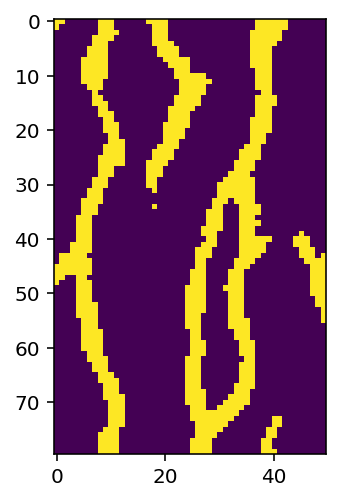

In [2]:
#Now importing and preprocessing of data
tr_im = np.loadtxt("reals.dat")
print (tr_im.shape)
nrow,ncol = 80,50
plt.imshow(tr_im[0,:].reshape(nrow,ncol))

#checking the range of values of our images as I don't think they match up with the ones from the example
print (tr_im.max(),tr_im.min())

#now transforming the array so that hopefully we get a range of -1 to 1
tr_im = (tr_im.astype(np.float32) - .5) / .5
print (tr_im.max(),tr_im.min())

In [3]:
#Setting up the loss fucntion and other variables needed to compile the final model



#number of standard normal deviates to feed to generator input
npar = 100

#defining the loss function
def d_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

#Setting our optimizer to make things flow easier later
opt = RMSprop(lr=0.0005)

#Here we are defining the d_iters which is the amount of times the discriminator updates per every generator update
d_iters = 5

In [4]:
#creating and compiling the discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding='same', input_shape=(1, 80, 50), kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(128, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.35))
discriminator.add(Conv2D(256, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(512, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Flatten())
output_is_fake = discriminator.add(Dense(1, activation='linear'))
discriminator.compile(loss=d_loss, optimizer=opt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 40, 25)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 40, 25)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 40, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 20, 13)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 20, 13)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 20, 13)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 10, 7)        819456    
__________

In [5]:
#creating the generator but not yet compiling it
generator = Sequential()
generator.add(Dense(npar*8*5, input_shape=(npar,), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((npar, 8, 5)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(256, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(128, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(5, 5)))
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4000)              404000    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4000)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 8, 5)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 100, 16, 10)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 16, 10)       640256    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256, 16, 10)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 16, 10)       819328    
__________

In [6]:
#Now we build and compile the final model

#defining the generator input
gi = keras.layers.Input(shape=(npar,))

#Creating the combined model
output_is_fake = discriminator(generator(inputs=gi))
WGAN = Model(inputs=gi, outputs=output_is_fake)

WGAN.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=d_loss
)

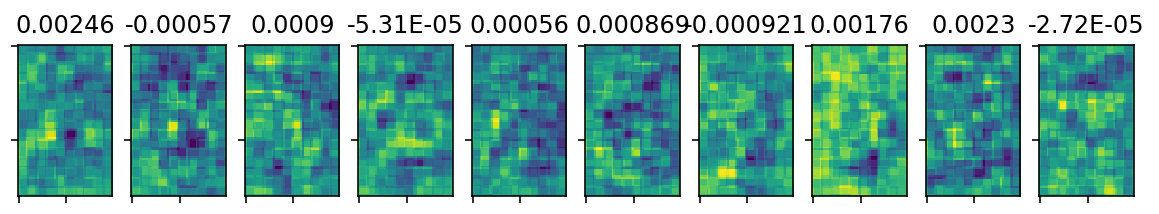

In [7]:
#defining the function for us to plot and save the generated images as we go
#This crashes the jupyter notebook if we write every one so instead I am just going to do this every 100 epocs
def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    #print(vecs[0,:])
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,nrow,ncol),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)

78


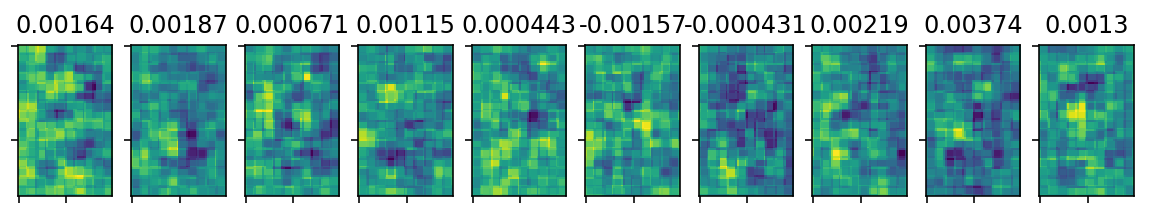

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 47.758377 6.9141164


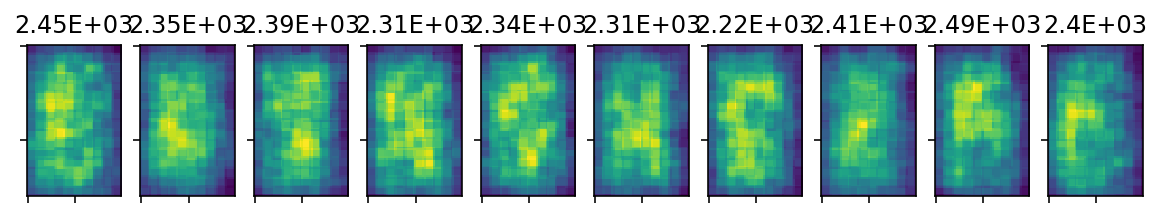

1 147.29047 -35.404568


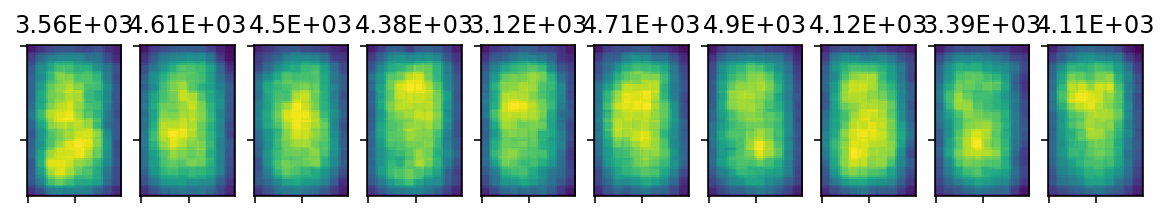

2 714.38806 -375.5329


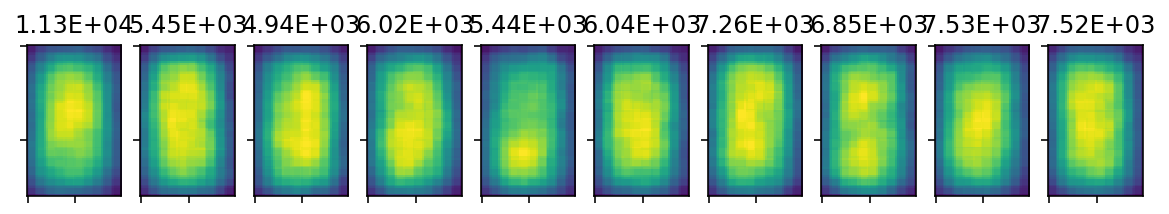

3 10.666104 184.29535


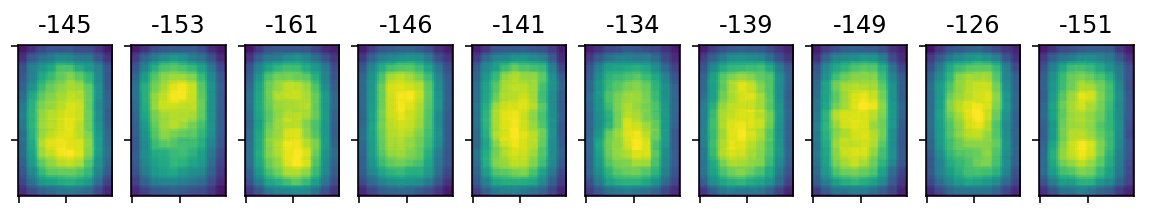

4 -71.24774 195.96727


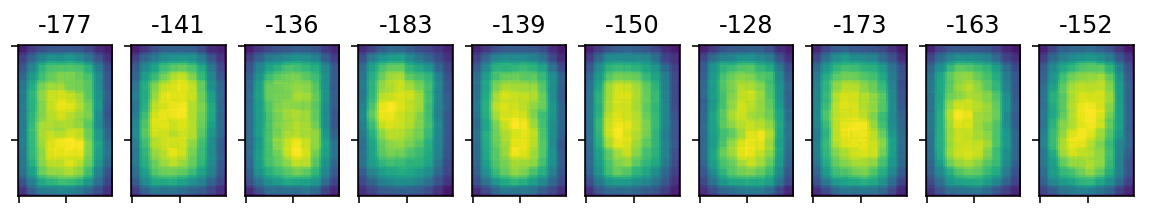

5 -44.401028 176.11879


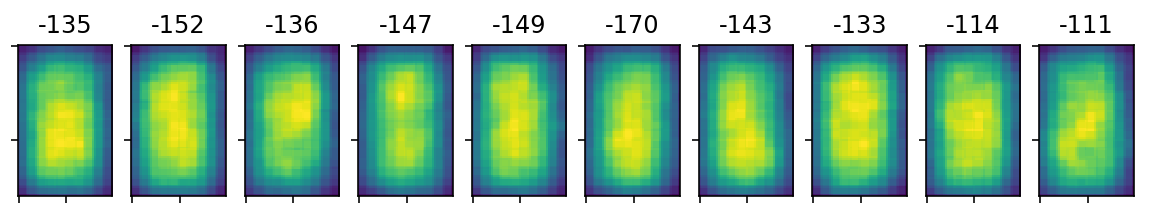

6 -43.16473 171.73538


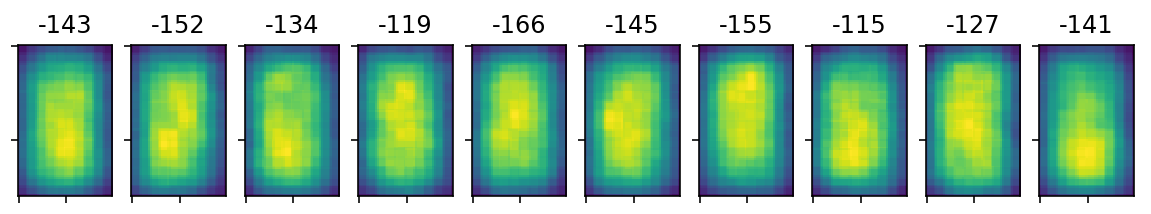

7 -37.488712 164.71033


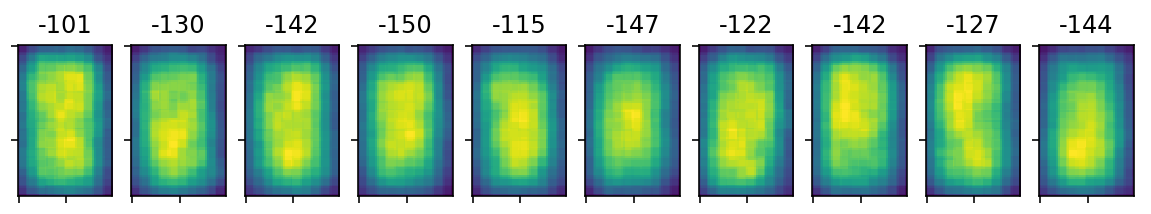

8 -33.067204 156.69493


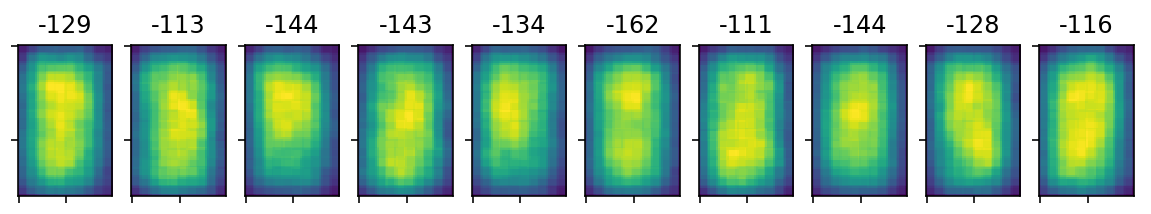

9 -27.064724 151.12514


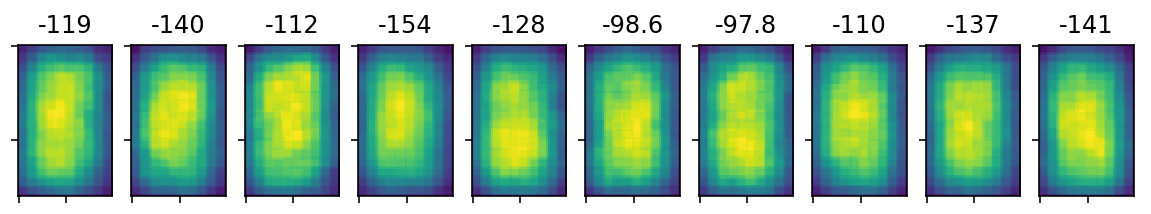

10 -23.795395 143.5894


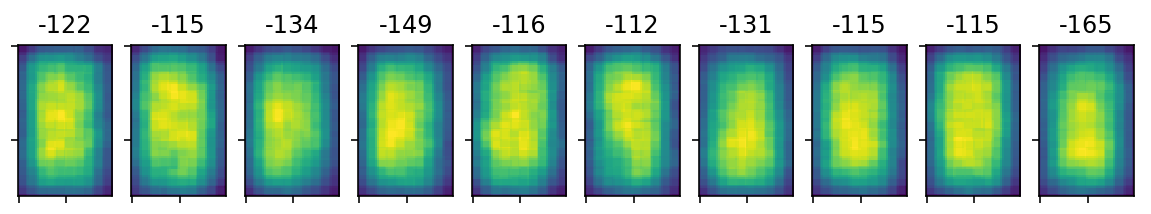

11 -14.942736 137.1074


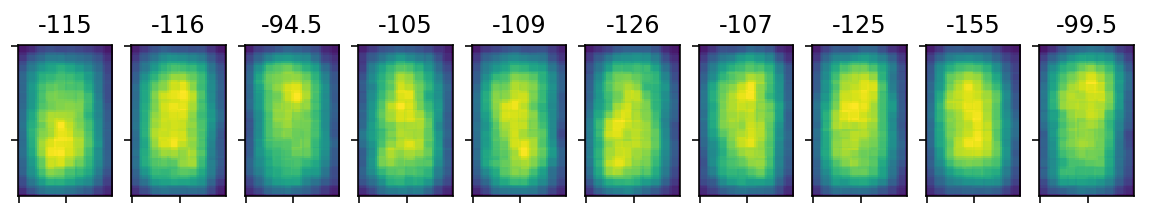

12 -9.141114 130.82257


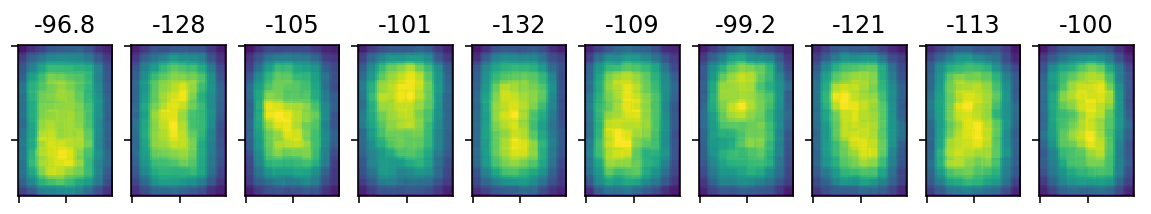

13 -3.0084531 123.90046


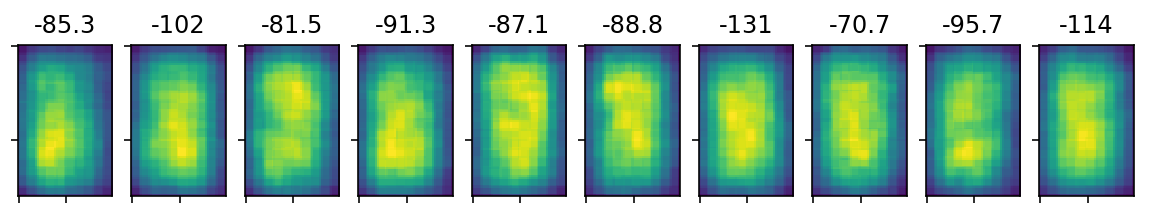

14 11.739915 112.84234


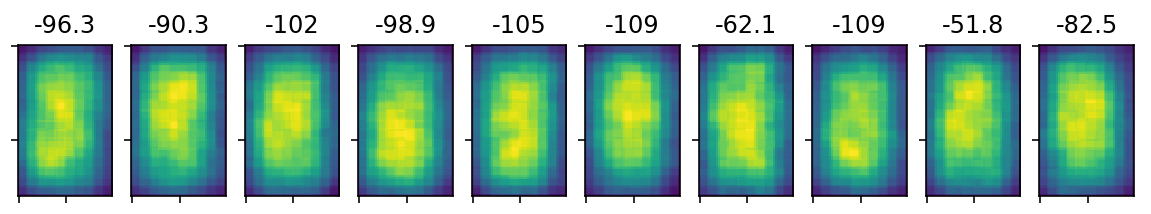

15 16.79207 104.60255


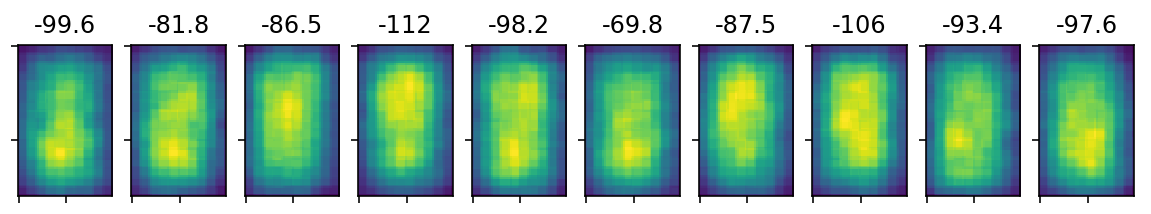

16 20.006433 97.73401


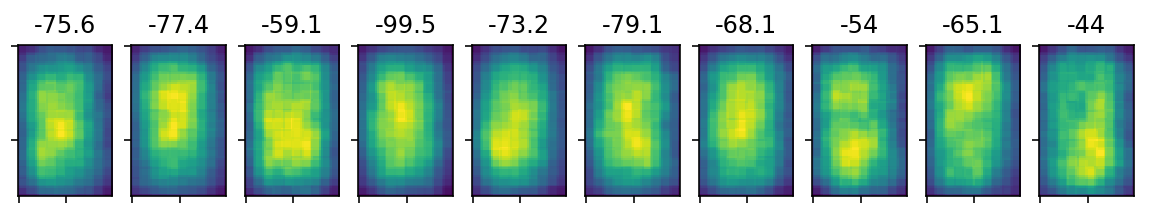

17 25.862825 91.33984


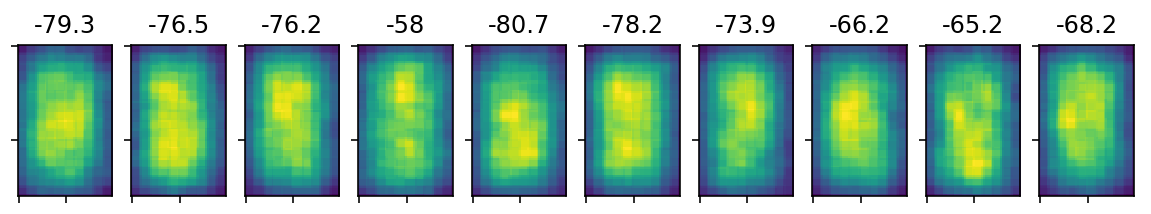

18 30.139894 81.77892


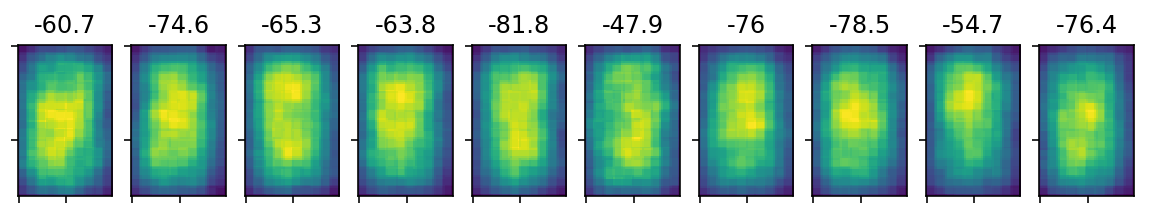

19 37.484867 78.21606


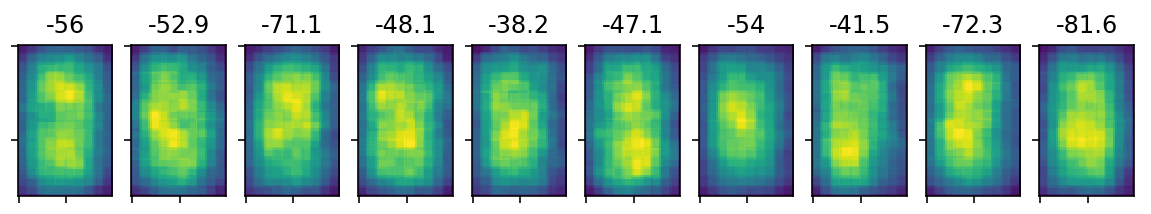

20 43.348206 68.53616


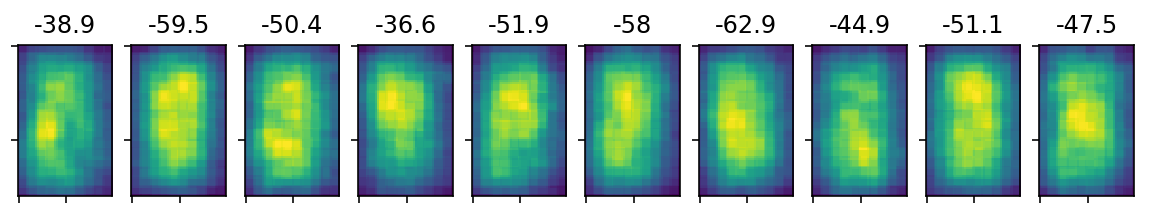

21 55.867493 57.305267


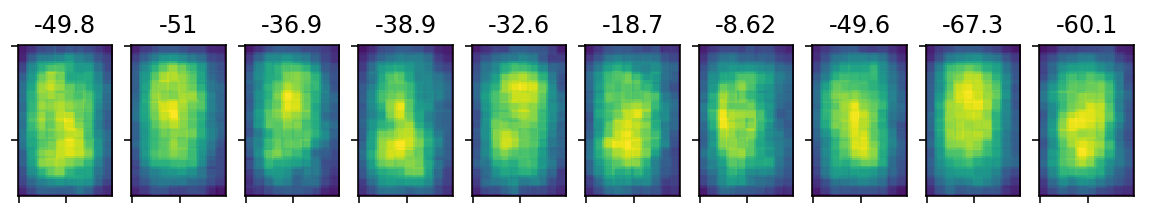

22 67.8102 45.006527


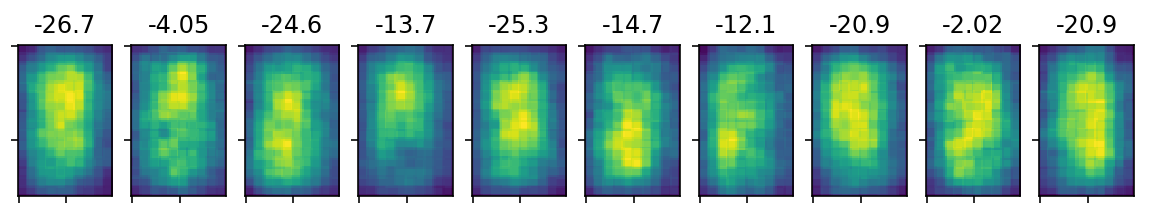

23 83.90821 33.52743


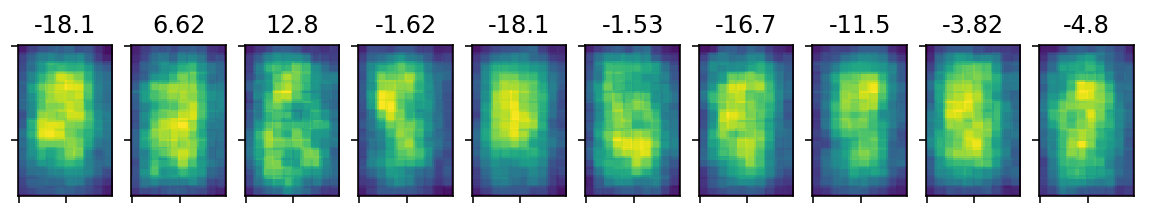

24 95.94366 19.23745


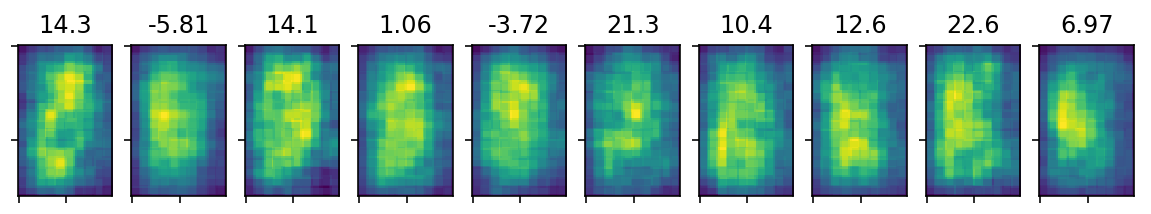

25 108.92137 5.7838626


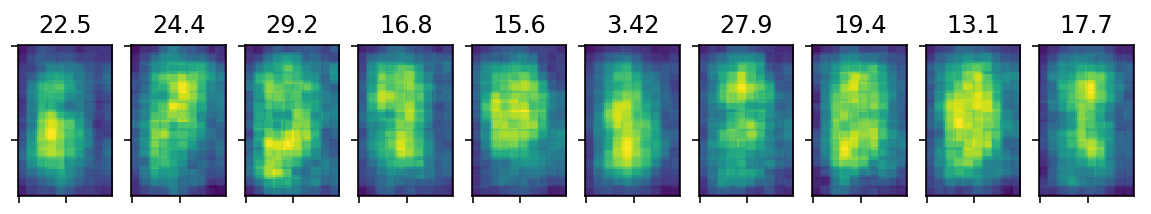

26 122.22594 -8.308135


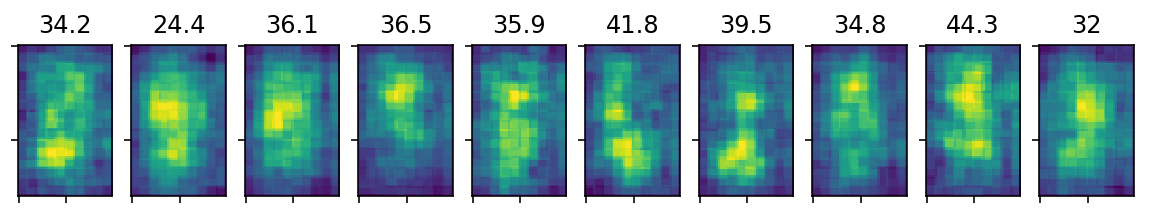

27 132.14825 -21.374743


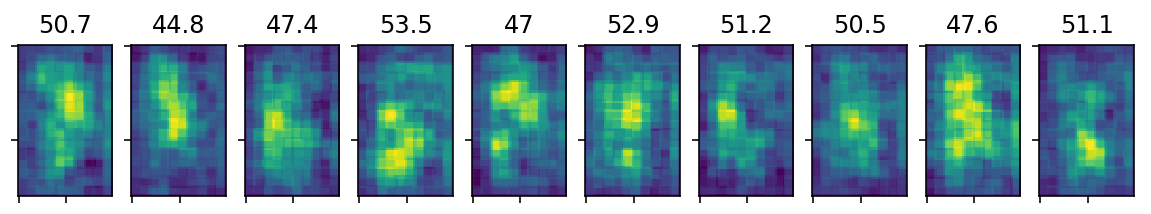

28 143.67085 -33.596115


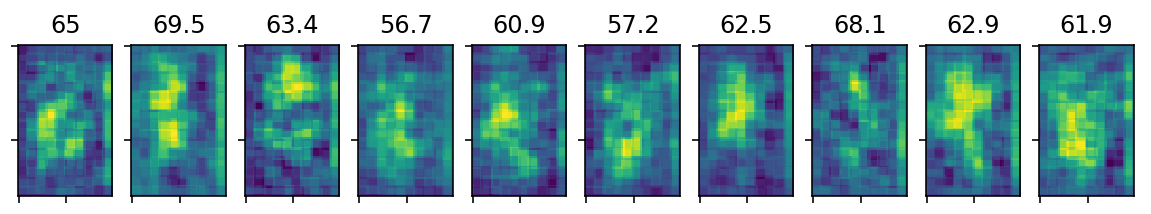

29 157.03941 -48.057552


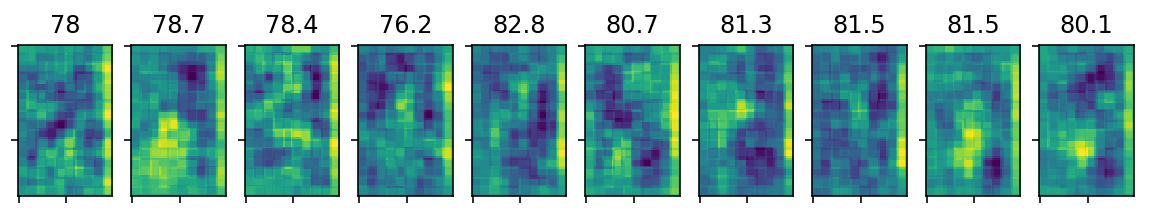

30 173.35782 -66.80106


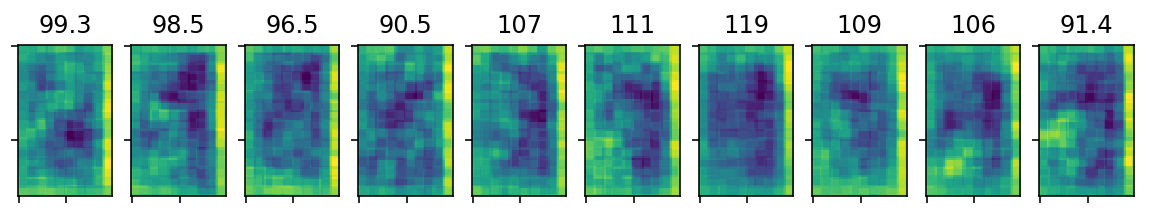

31 188.22462 -82.13947


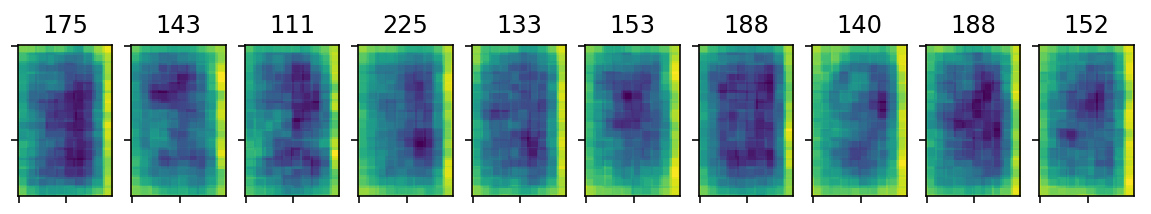

32 253.73439 -101.29056


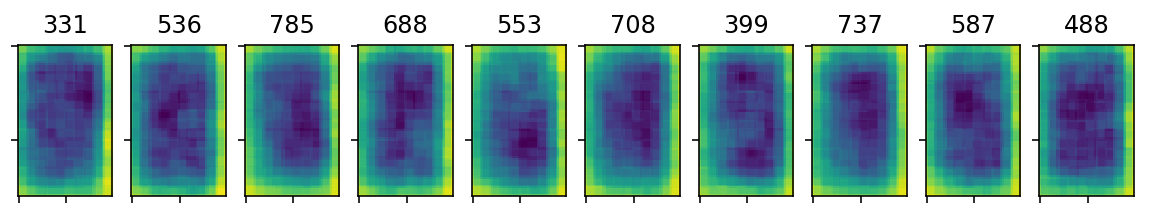

33 683.67145 -469.34573


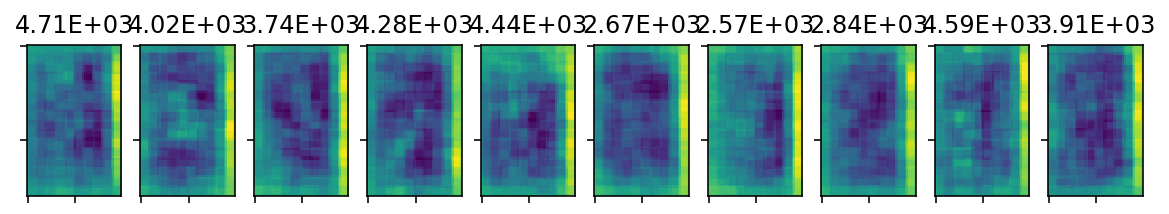

34 530.3853 -312.37524


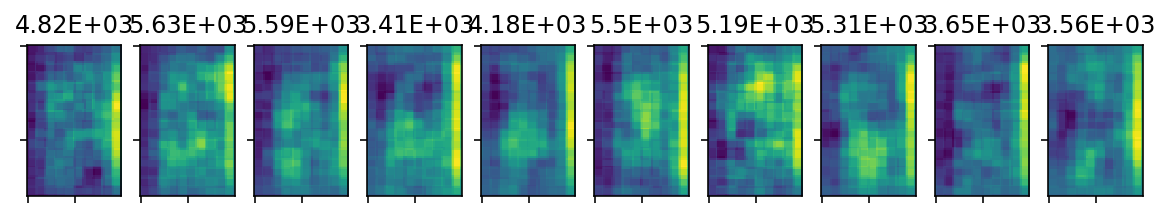

35 477.5454 -240.29129


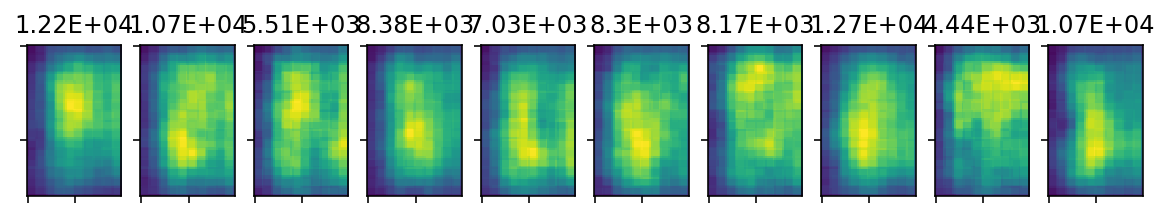

36 888.73334 -478.51028


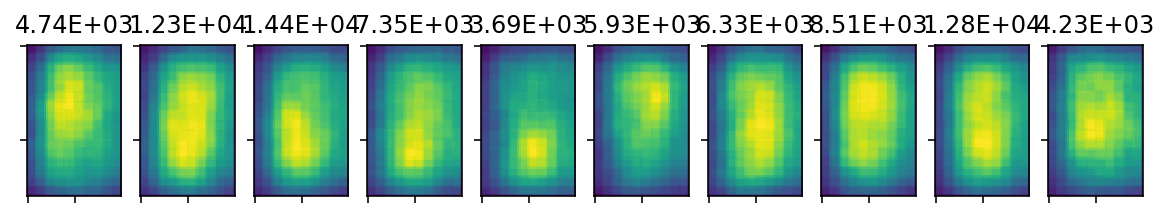

37 788.4067 -739.69293


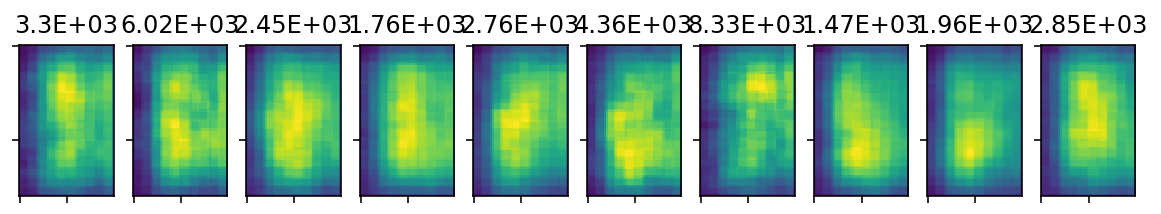

38 2549.6575 -2438.8242


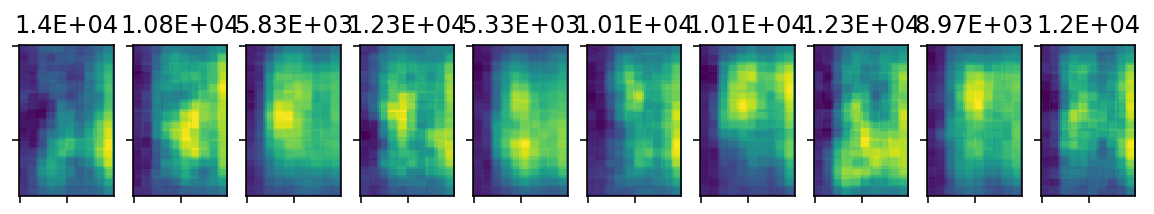

39 3459.8833 -2834.1304


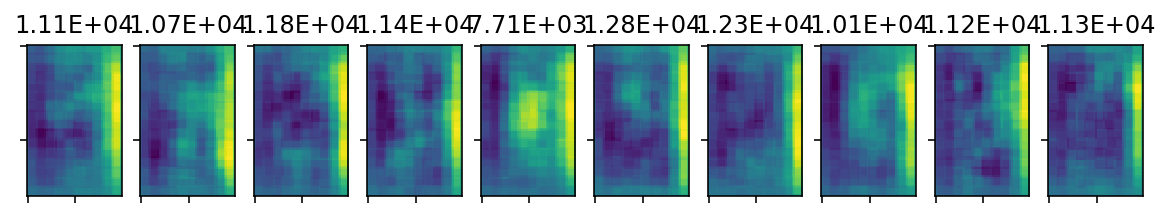

40 2374.1943 -1740.7704


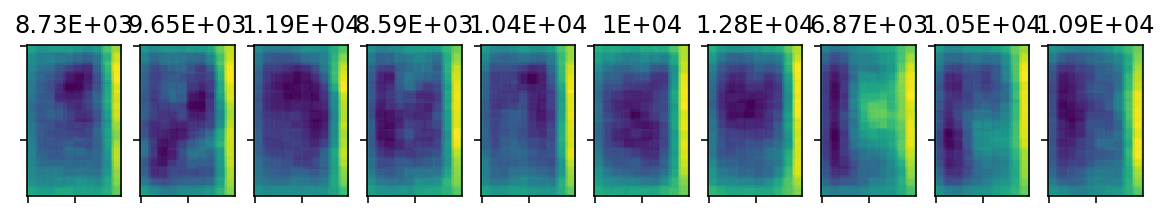

41 2963.9768 -2530.3916


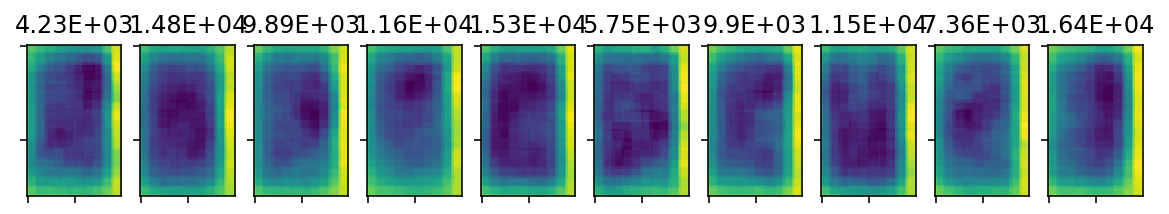

42 7961.171 -6267.278


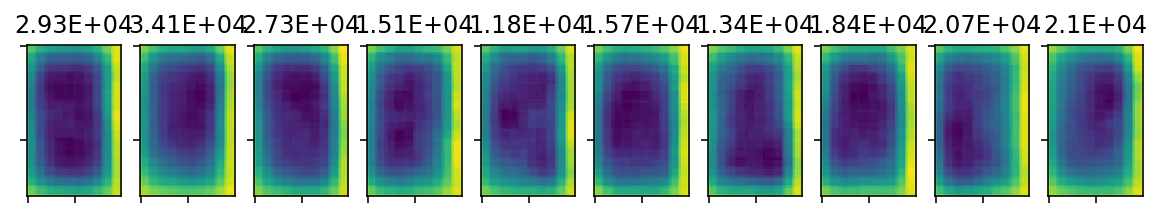

43 19185.783 -16370.03


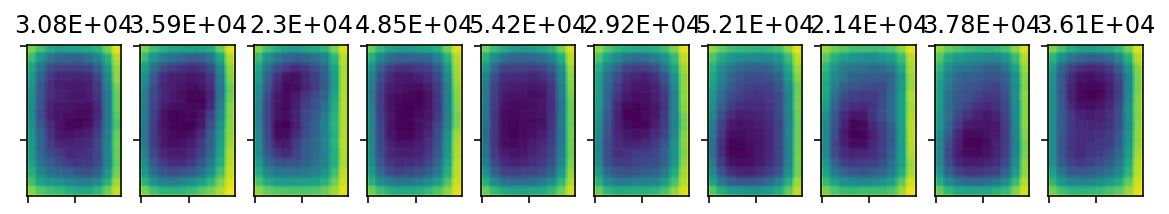

44 34261.582 -26237.768


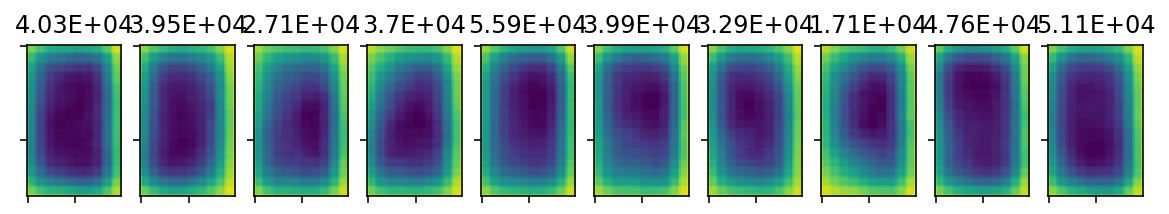

45 43761.07 -32950.2


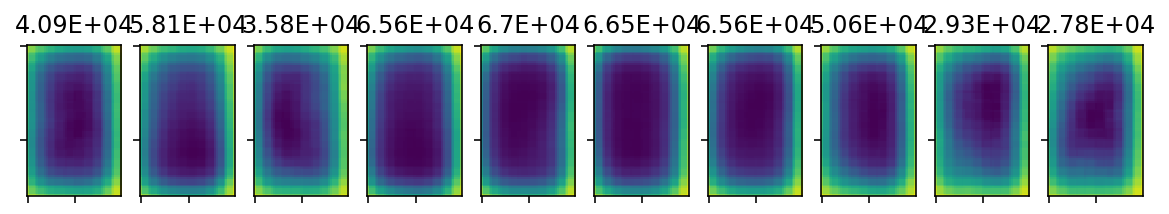

46 3276.531 -1579.8411


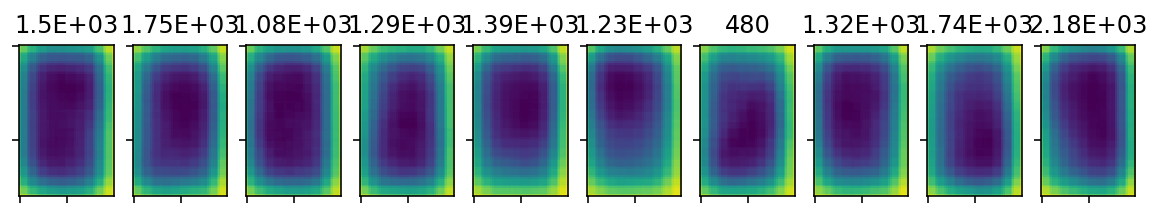

47 -880.2768 3140.5354


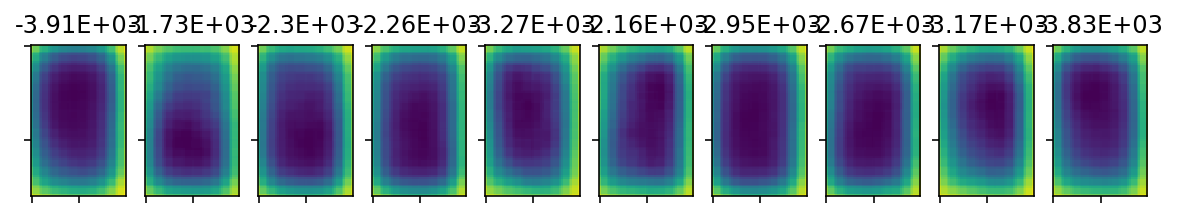

48 -3488.1501 6658.191


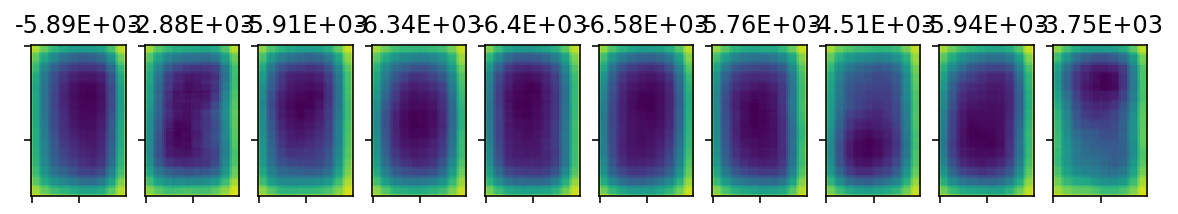

49 -3389.4888 6441.203


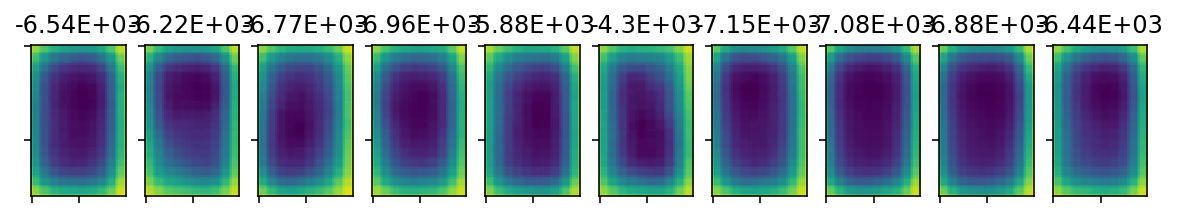

50 -3186.1772 6097.946


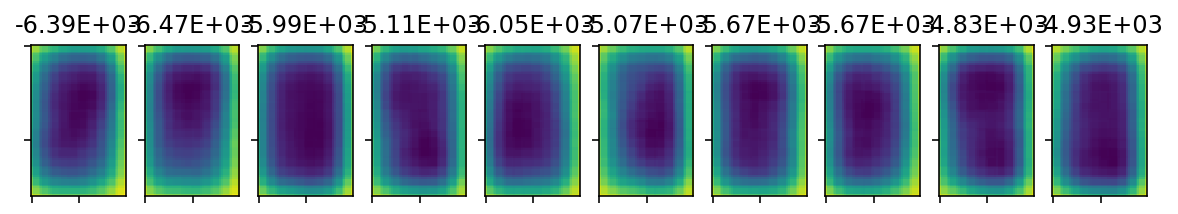

51 -2944.4434 5824.7793


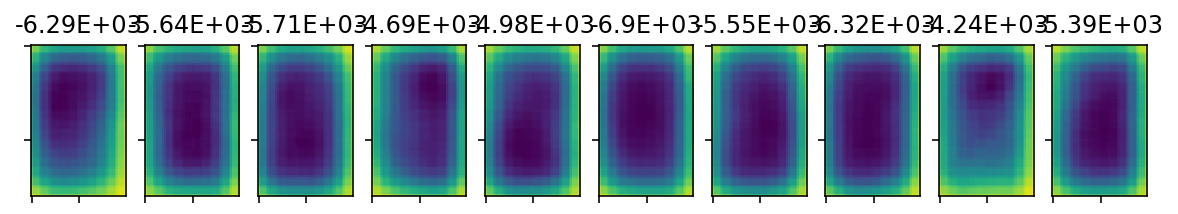

52 -2714.9705 5486.1836


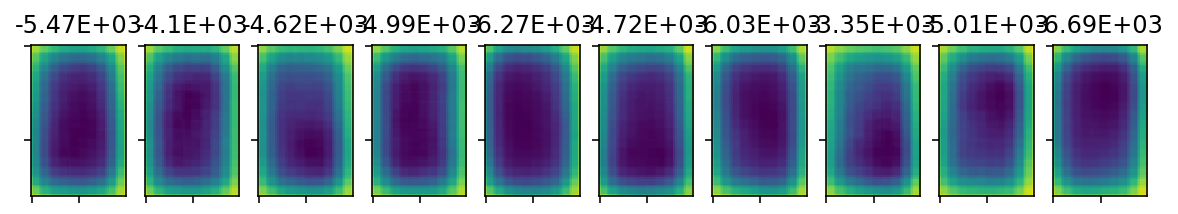

53 -2538.4043 5312.3335


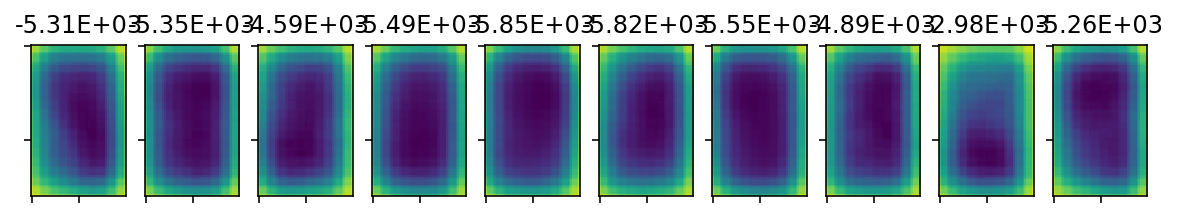

54 -2402.0188 4982.8574


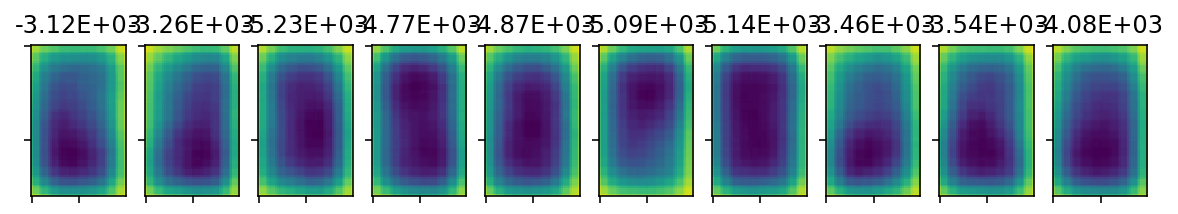

55 -2090.9856 4600.438


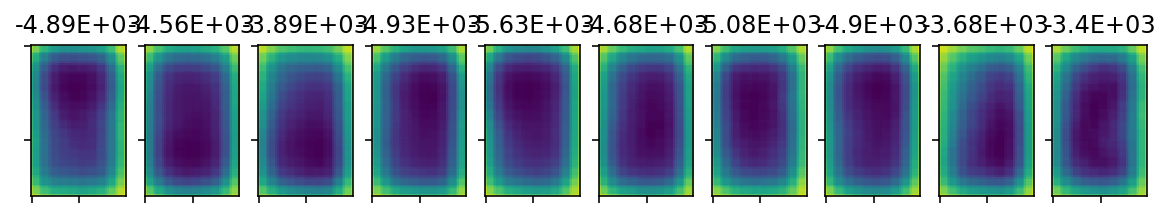

56 -1848.8136 4306.305


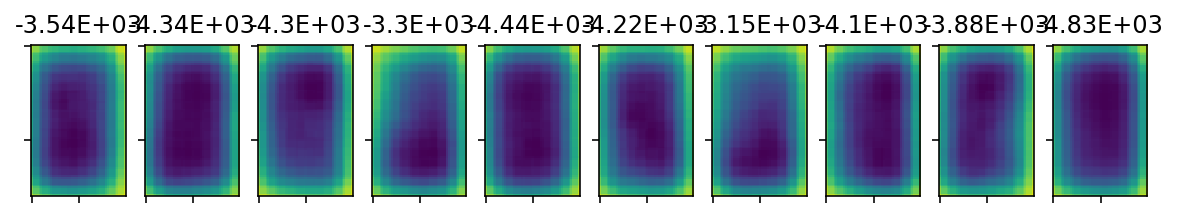

57 -1775.5624 4000.967


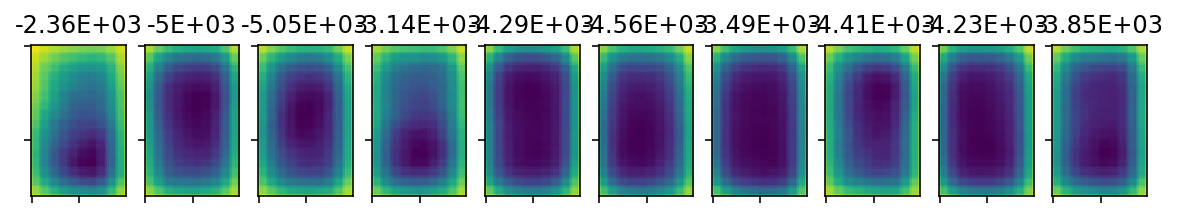

58 -1710.3739 3812.6895


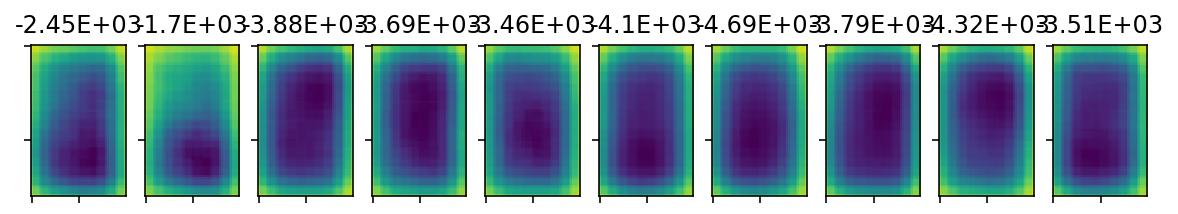

59 -1804.7595 3769.0938


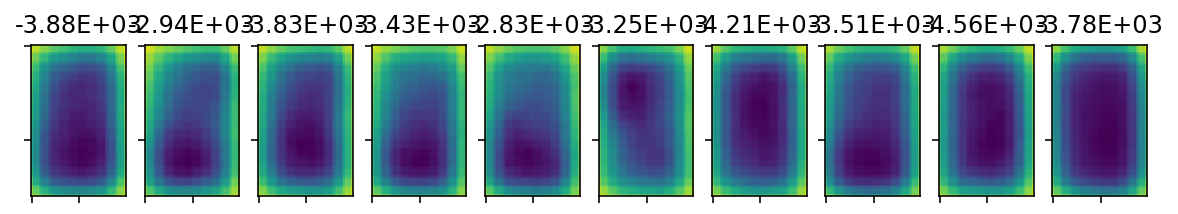

60 -1693.5071 3669.3806


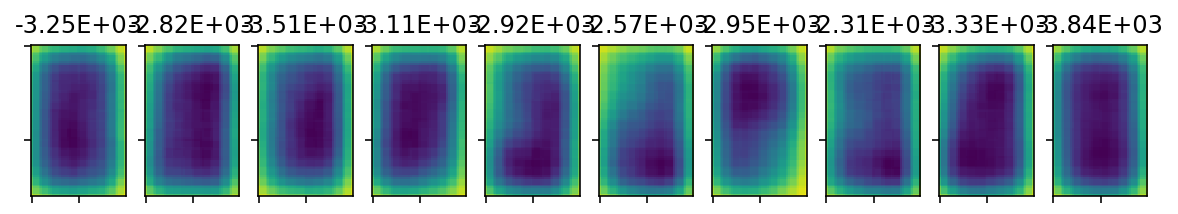

61 -1587.3706 3436.3481


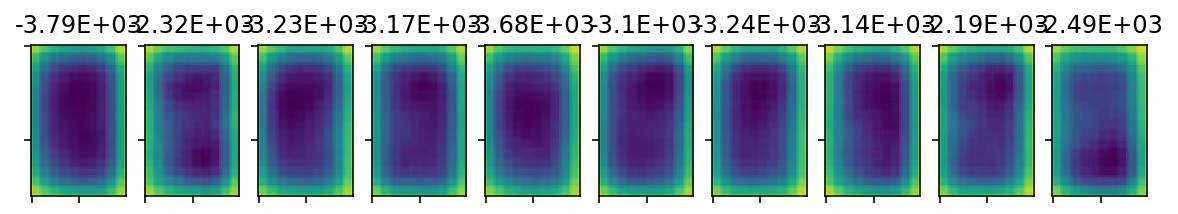

62 -1408.8553 3120.9678


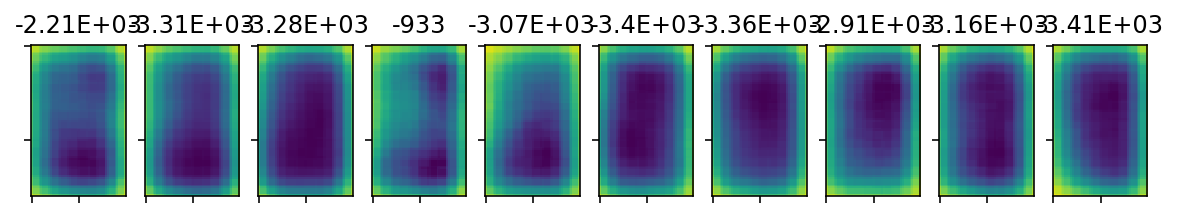

63 -1319.664 2914.1702


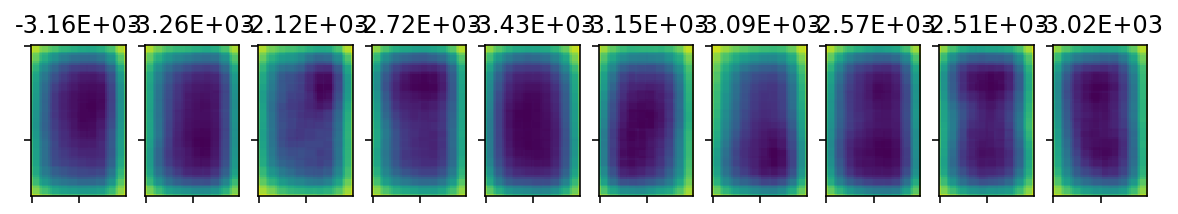

64 -1178.206 2650.1172


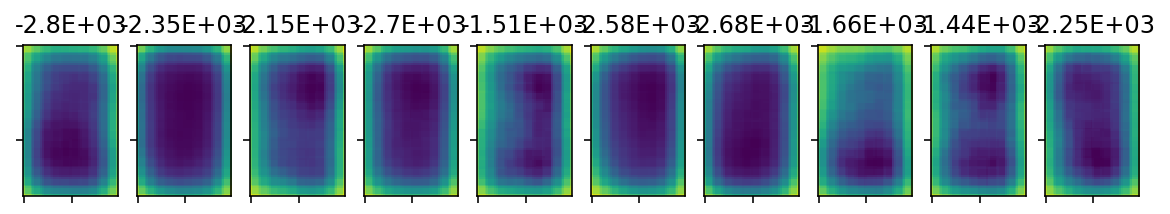

65 -1061.9169 2428.832


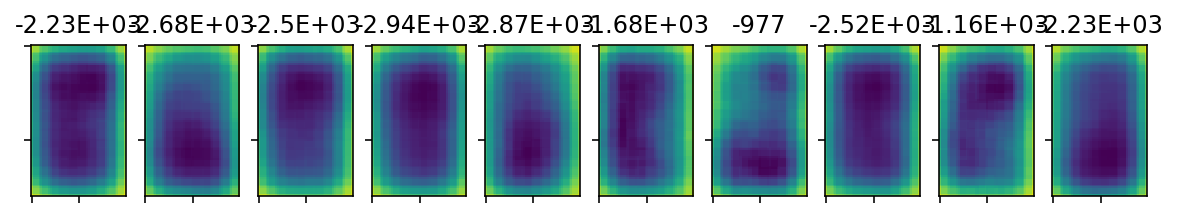

66 -968.0985 2122.213


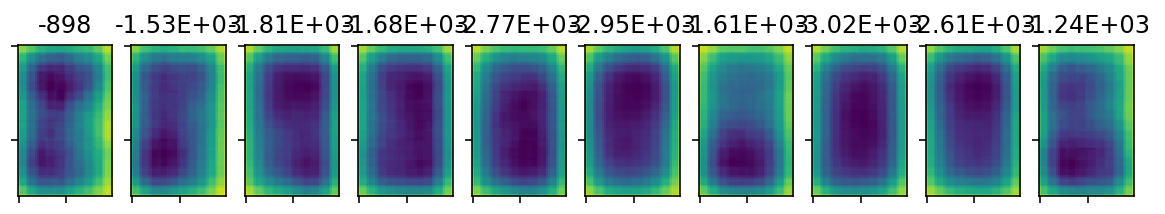

67 -798.0284 1991.9548


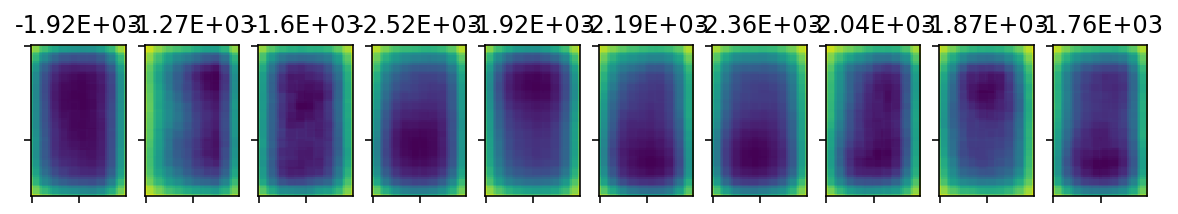

68 -690.0102 1740.9661


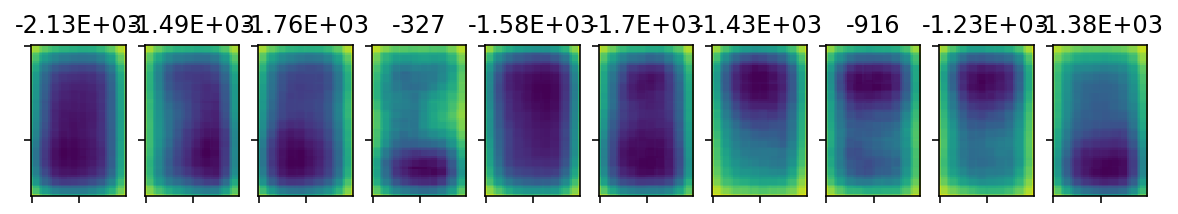

69 -623.9926 1781.5558


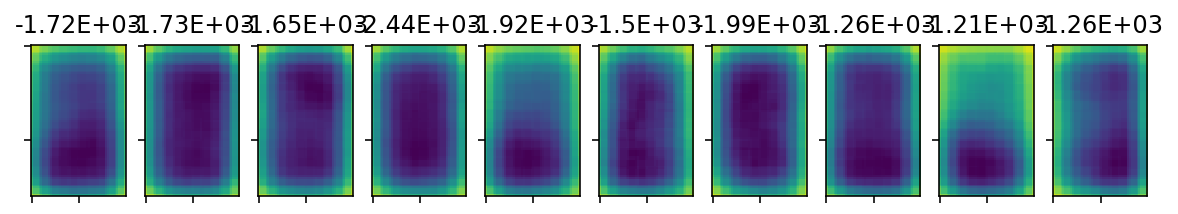

70 -458.72214 1527.1837


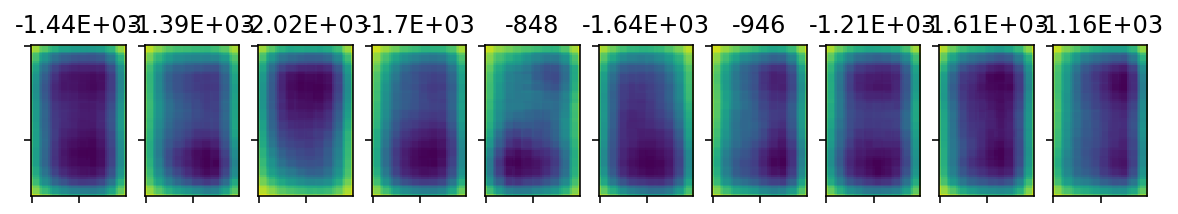

71 -387.25998 1435.6271


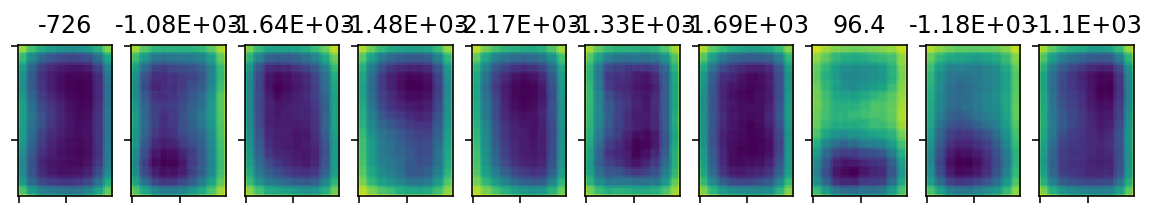

72 -312.979 1299.0732


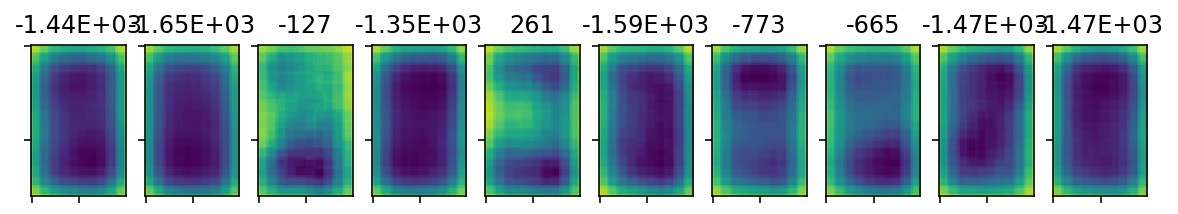

73 -281.52676 1260.9912


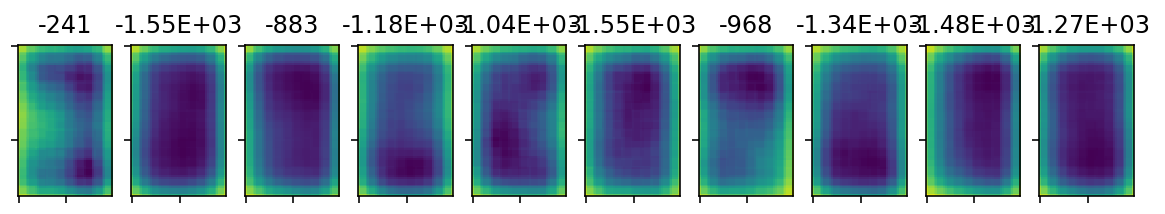

74 -250.02672 1226.4354


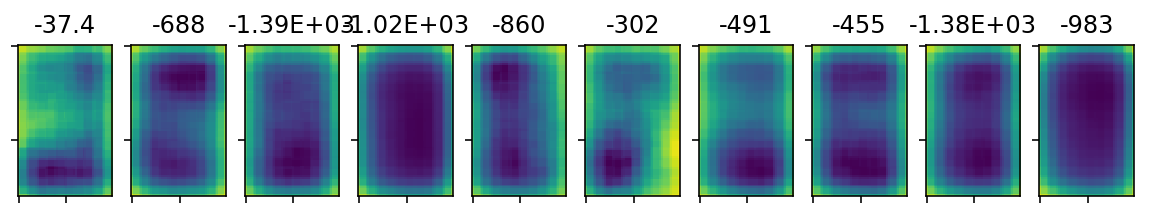

75 -215.74098 1268.0907


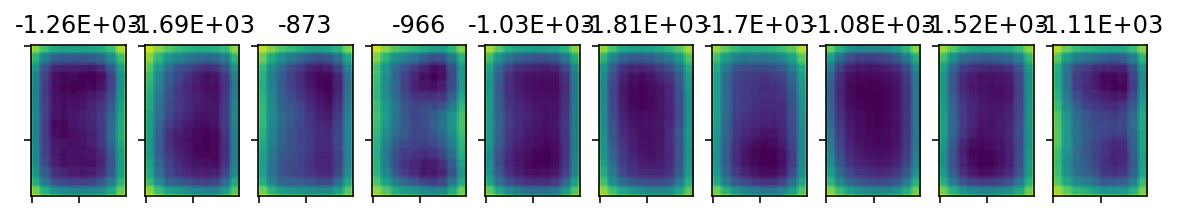

76 -298.56067 1289.3824


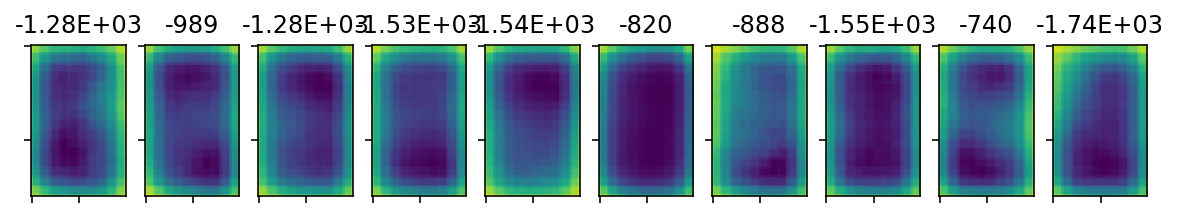

77 -323.64328 1345.141


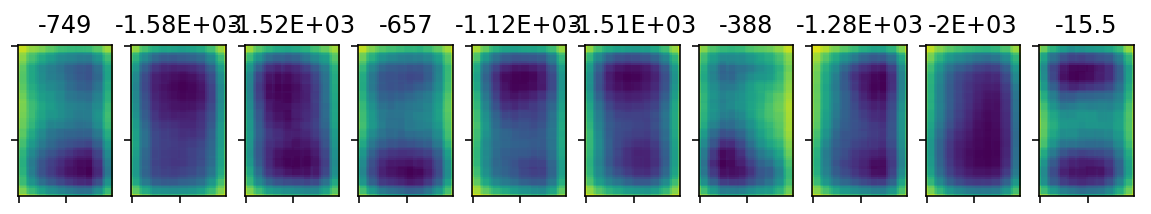

78 -345.17386 1380.3523


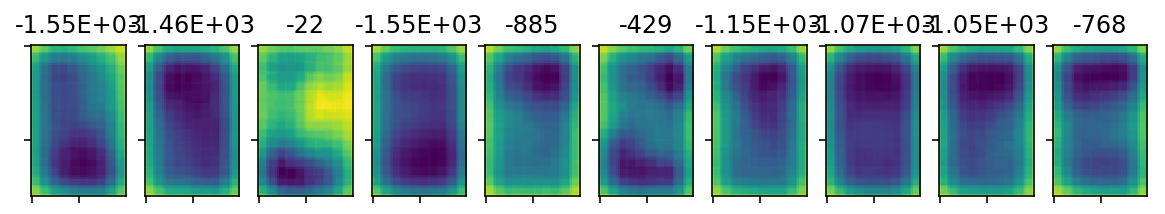

79 -294.49362 1234.7295


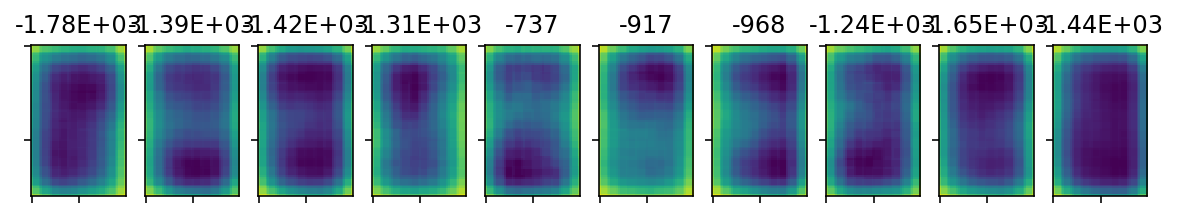

80 -276.21365 1235.6549


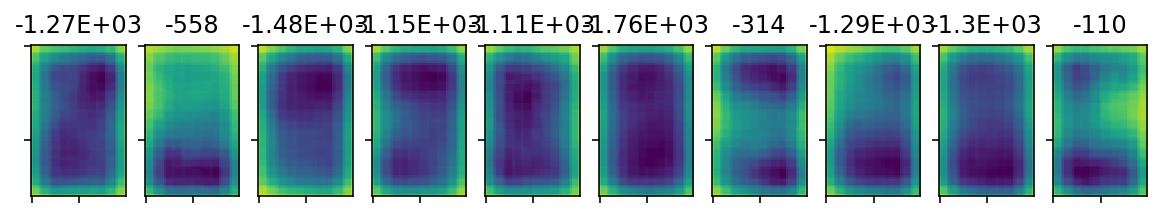

81 -52.014187 884.50824


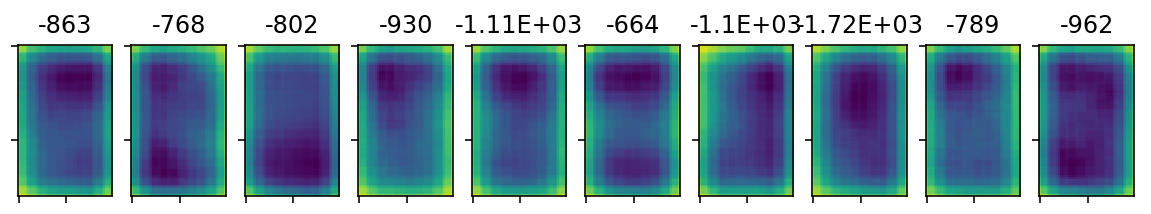

82 210.33128 586.69525


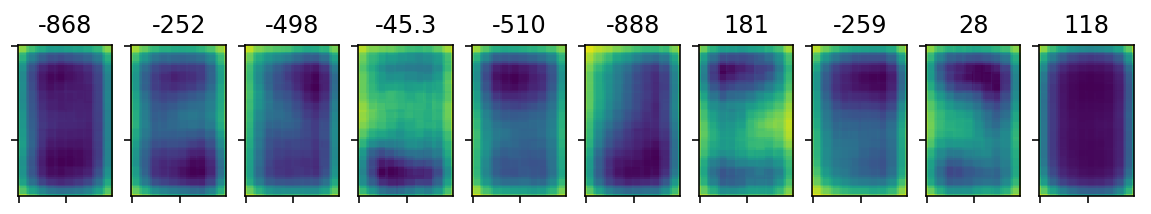

83 517.01556 394.64917


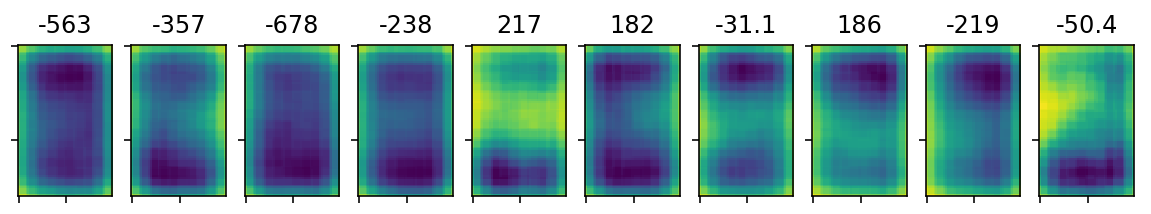

84 723.77563 138.24232


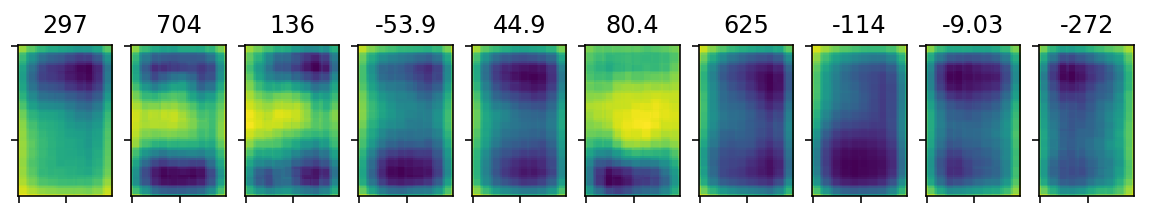

85 850.6191 13.468675


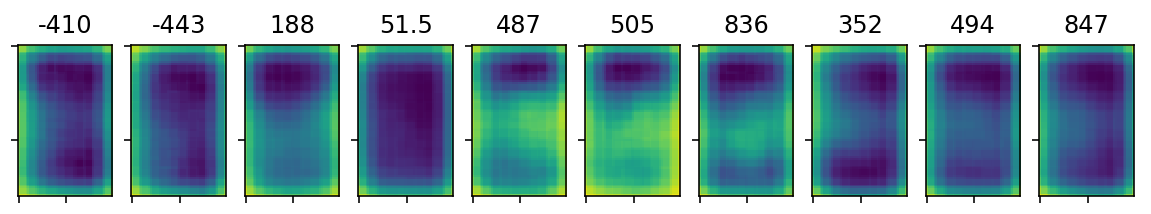

86 774.2626 76.552216


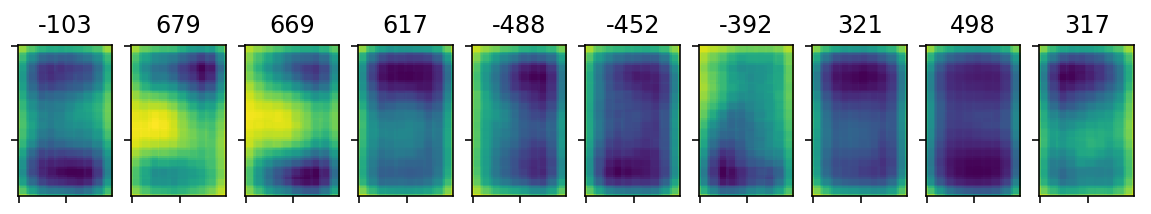

87 519.52124 261.66568


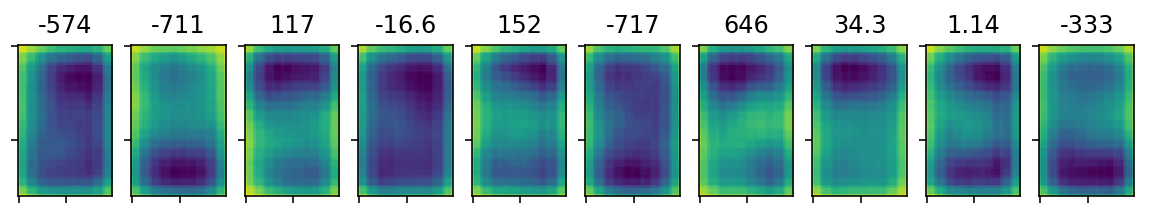

88 413.967 423.97388


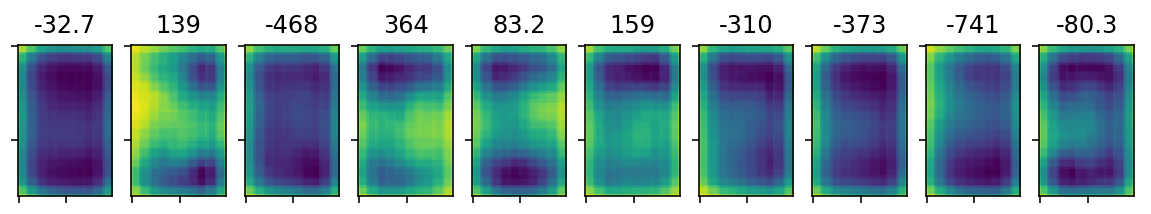

89 466.4104 312.7889


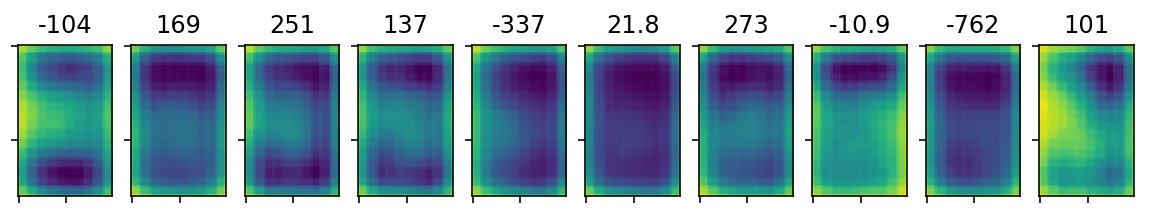

90 598.9808 51.054993


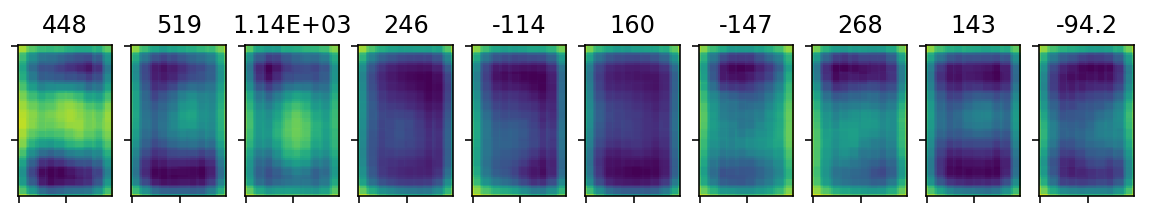

91 855.0458 -279.89883


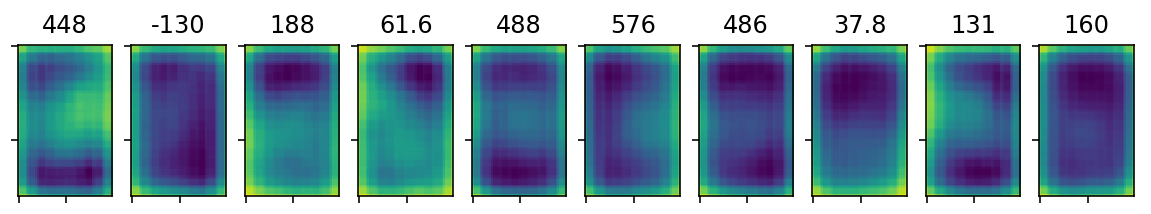

92 911.5679 -362.8191


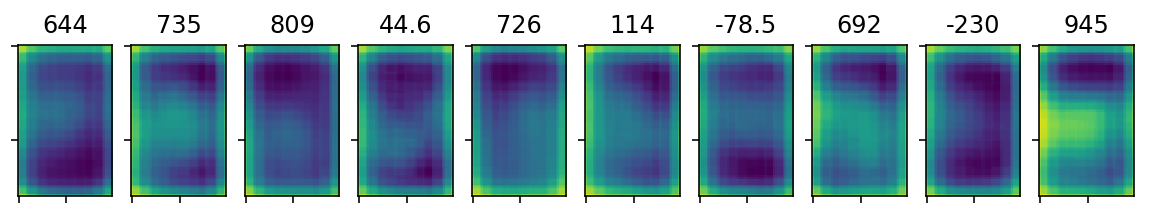

93 873.02246 -254.05482


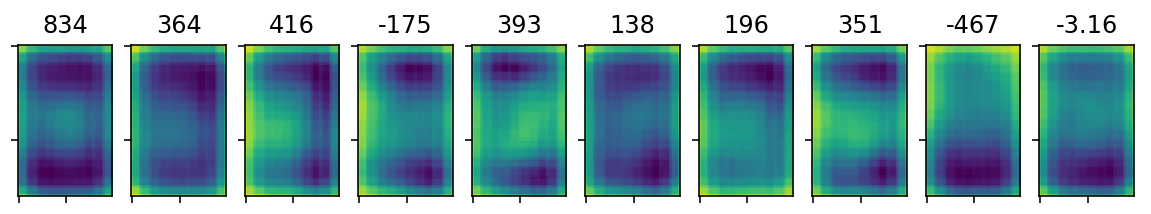

94 661.38385 -104.149155


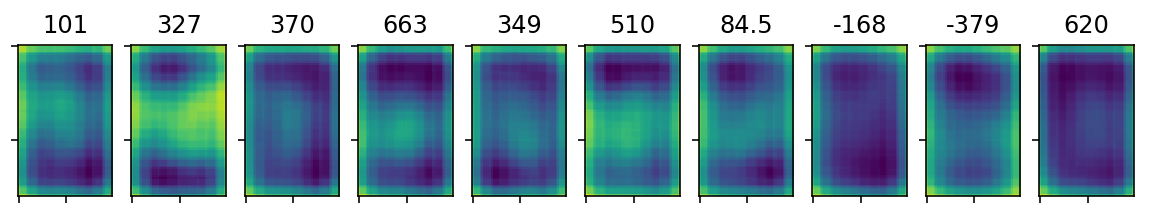

95 622.6973 -128.59587


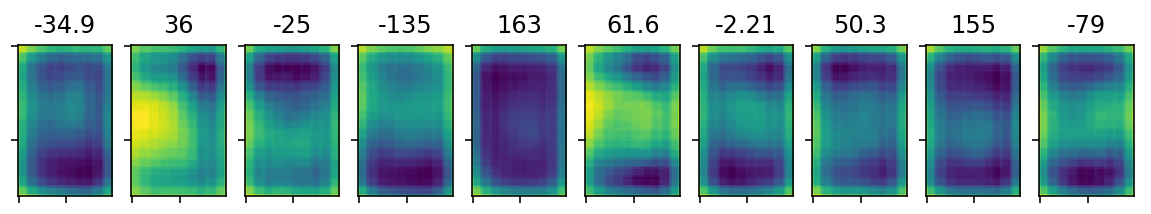

96 622.0616 -121.71138


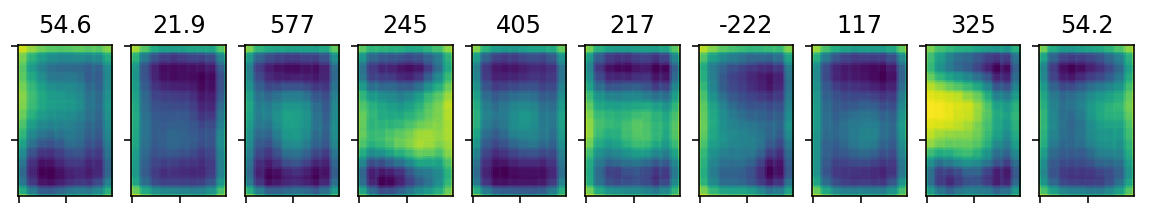

97 785.77155 -284.32083


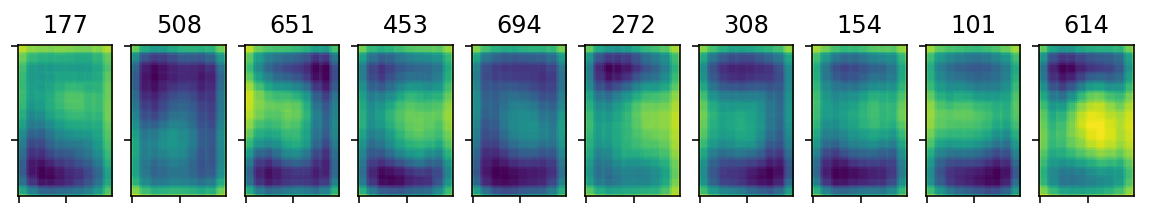

98 780.5187 -312.17236


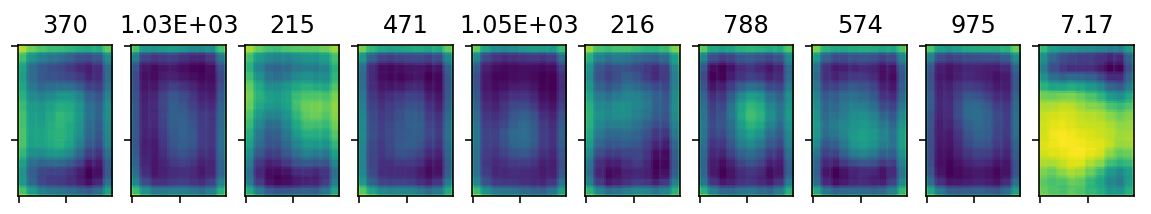

99 748.7275 -299.83395


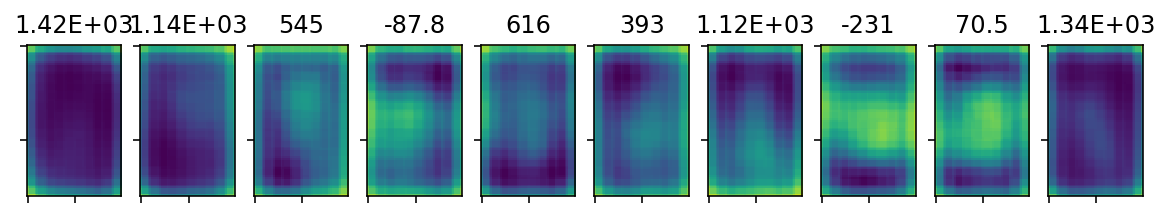

In [8]:
#Now we are going to define the paramaters for training and create our final training loop

batch_size = 256
assert batch_size % 2 == 0
half_batch_size = int(batch_size / 2)
batch_count = int(tr_im.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
gloss,dloss,gavg,davg, WGANloss = [],[],[],[],[]
tr_im_batch = tr_im[np.random.randint(0,tr_im.shape[0],size=batch_size)]
tr_im_batch = np.resize(tr_im_batch,(batch_size,1,nrow,ncol))
for e in range (2400):
    
    if (e % 1000) < 25 or e % 500 == 0:
        d_iters = 100
    else:
        d_iters = d_iters
        
    for d_it in range (d_iters):
        
        discriminator.trainable = True
        for l in discriminator.layers: l.trainable = True
            
        for l in discriminator.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)
            
        index = np.random.choice(len(tr_im), batch_count, replace=False)
        real_images = tr_im[index]
        
        d_loss = discriminator.train_on_batch(tr_im_batch, [-np.ones(batch_size)])
        dloss.append(d_loss)
        
        zz = np.random.normal(0, 1, (batch_size, npar))
        generated_images = generator.predict([zz])
        
        d_loss = discriminator.train_on_batch(generated_images, [np.ones(batch_size)])
        
        
        
    discriminator.trainable = False
    for l in discriminator.layers: l.trainable = False
        
    zz = np.random.normal(0, 1, (batch_size, npar))
    
    WGAN_loss = WGAN.train_on_batch(
        [zz],
        [-np.ones(batch_size)])
    
    WGANloss.append(WGAN_loss)
    
   
    if e % 100 == 0:
        print(e,d_loss,WGAN_loss)
        
    if e % 100 == 0:
        plot_gen()
        plt.show()
        
    if e % 100 ==0:
        generator.save(os.path.join(o_d,"gen_{0}.h5").format(e))
    
    if e % 100 ==0:
        discriminator.save(os.path.join(o_d,"dis_{0}.h5").format(e))

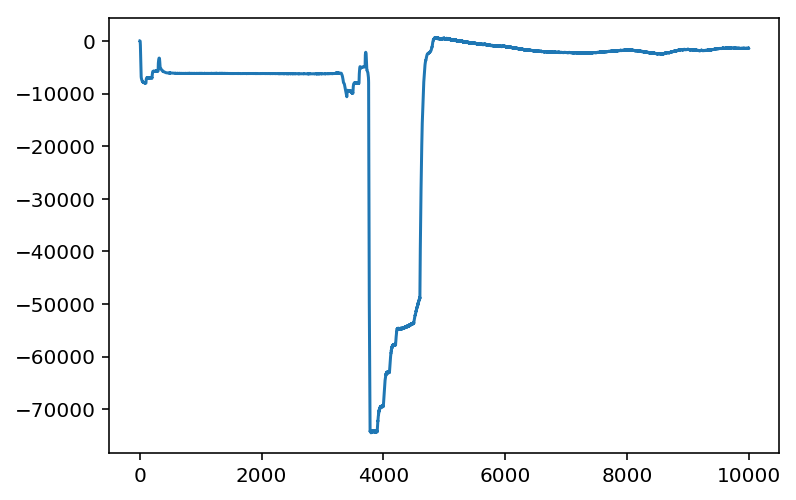

In [9]:
plt.plot(dloss)

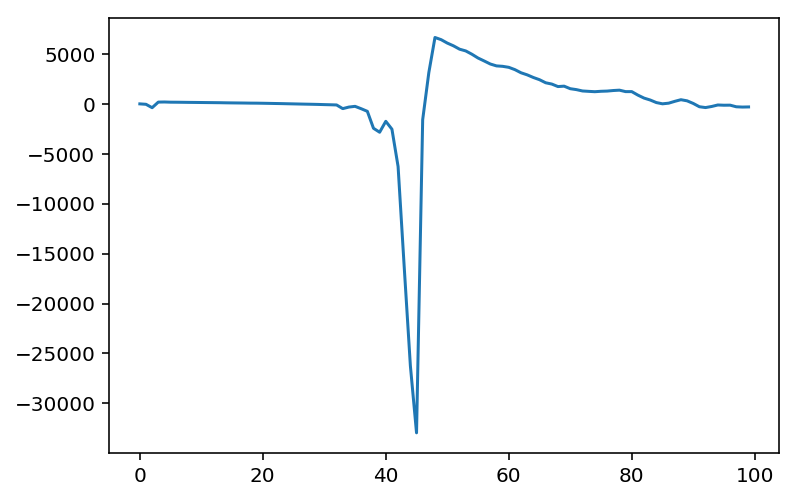

In [10]:
plt.plot(WGANloss)